## Logging and plotting data

In the last practical session we saw how to define, attach, start, stop and detach routines to the ePuck robots. Here we are going to see how to use such routines to record data perceived or produced by the robots. This will allow the plotting of figures either here in the notebook or in a separate PNG image for your report. This can also be useful to better visualize what is happening in your simulation and help you debugging it. 

Let's start with a simple example where we record the values returned by both proximeters through time. In V-REP, load the scene called `epuck-scene-5.ttt` in `pyvrep_epuck/vrep_scenes`. Then connect to the simulator as usual:

In [1]:
from simulator_interface import open_session, close_session
simulator, epuck1, epuck2 = open_session(n_epucks=2)

Recording data is realized by the `add_log` function of the ePuck, which require two arguments: the arbitrary label of the recorded data, called the topic, and the data to be recorded. For example:

In [ ]:
epuck1.add_log("test", 1)

This stores the data `1` in a topic that we arbitrarily call `"test"`. We can retrieve this data by using the `get_log` function , which requires as argument the name of the topic (`"test"` in this example):

In [ ]:
print epuck1.get_log("test")

Calling `epuck1.get_log("test")` returns the list of the data recorded in the topic `"test"` by `epuck1`. Here it prints `[1]`, a list containing the only data we have stored before.

Let's add another data to the same topic:

In [ ]:
epuck1.add_log("test", 42)

And retrieve the data recorded on this topic:

In [ ]:
print epuck1.get_log("test")

The second value we have added, `42`, has been appended to the list, which now contains the two recorded data.

We can add another value to another topic:

In [ ]:
epuck1.add_log("another_topic", 18)

and retrieve it using `get_log`, this time with the name of this new topic:

In [ ]:
print epuck1.get_log("another_topic")

Of course the data recorded before in the topic `"test"` is still accessible:

In [ ]:
print epuck1.get_log("test")

The names chosen for the topics are completely arbitrary. They are just tags that you choose for organizing the data according to their source.

This two functions allow to record various data from the simulation, organizing them by topics differentiated by their names. Coupled with an appropriate routine running on the ePuck that continuously calls the `add_log` function, for example to record the values of the proximeters or the motors through time, this can then be used for generating figures plotting what is happening in the simulation.

Let's define a routine that record the values sensed by the left and right proximeters:

In [ ]:
# Define a routine using the method we have seen in the last session. Here we call it epuck_log 
def epuck_log(robot):
    # Retrieve the values of the left and right proximeters:
    left, right = robot.prox_activations()
    
    # record the left activation in the topic called "left_prox"
    robot.add_log("left_prox", left)
    # record the right activation in the topic called "right_prox"
    robot.add_log("right_prox", right)

and attach and start it on `epuck1` as usual:

In [ ]:
epuck1.attach_routine(epuck_log, freq=1)
epuck1.start_routine(epuck_log)

We set a frequency of 1Hz for the `epuck_log` routine, meaning that the left and right proximeter values will be recorded each second. We could put a higher frequency for having more precision, but keep in mind that this could cause memory issues, since the data are recorded continuously at the specified frequency. For example, with a frequency of 10Hz, it will record $60*10=600$ values each minute of the simulation. So it can take a lot of space in memory if you let the simulation running for a long time.

You can access to the values recorded from the left proximeter with:

In [ ]:
print epuck1.get_log("left_prox")

This prints all the recorded values for the left proximeter. All values are here similar because the epuck is not moving (no behavior is attached for the time being). In V-REP, try to move the robot corresponding to `epuck1` (i.e. the one called `ePuck` in V-REP) and observe the change in the recorded values by re-executing the cell above. In case there is too much values to be printed, you can clear the log by executing:

In [ ]:
epuck1.clear_all_logs()

This will erase all the data that `epuck1` has recorded. Recording will however still continue to occur because the `epuck_log` routine is still runnning. You can stop the routine as usual:

In [ ]:
epuck1.stop_routine(epuck_log)

Now the data are not recorded anymore.

Let's now define a population of robots foraging for spheres according to their glucose level as in the last session. We will also define a routine continuously recording various data during the simulation, for example proximeter activations or glucose levels.

First we define the obstacle avoidance behavior:

In [2]:
def obstacle_avoidance(robot):
    left, right = robot.prox_activations(tracked_objects=["20cm", "Tree", "Cup"])
    left_wheel = 1 - right
    right_wheel = 1 - left   
    return left_wheel, right_wheel

Then the routine that compute the glucose level:

In [3]:
def foraging_drive(robot): 
    if robot.has_eaten():
        robot.glucose_level += 0.2  # if the robot has eaten a sphere, increase its glucose level by 0.2
    else:
        robot.glucose_level -= 0.01  # otherwise (nothing eaten), decrease the glucose level by 0.01
    # The line below bounds the value of the glucose level between 0 and 1
    robot.glucose_level = min(1., max(robot.glucose_level, 0.))

Then we define the foraging behavior, which is weighted according to the glucose level (due to the last returned value, here `1-robot.glucose_level` because we want the foraging behavior to be more activated when the glucose level is lower:

In [4]:
def foraging(robot):
    left, right = robot.prox_activations(tracked_objects=["Sphere"])
    left_activation = right
    right_activation = left
    # Return the left and right wheel activation, as well the weight of the behavior according to the current glucose level
    return left_activation, right_activation, 1. - robot.glucose_level

And finally we define the routine that will log the data we are interested in (here the left and right activations of the proximeters and the wheels, as well as the glucose level of the robot):

In [5]:
# Define a routine using the method we have seen in the last session. Here we call it epuck_log 
def epuck_log(robot):
    # Retrieve the values of the left and right proximeters:
    left, right = robot.prox_activations()
    
    # record the left proximeter activation in the topic called "left_prox"
    robot.add_log("left_prox", left)
    # record the right proximeter activation in the topic called "right_prox"
    robot.add_log("right_prox", right)
    # record the glucose level in the topic called "glucose"
    robot.add_log("glucose", robot.glucose_level)

Now we can attach and start all the behaviors and routines we have just define on the two robots:

In [6]:
# First start sphere apparition in the environment:
simulator.start_sphere_apparition(period=5)

# For all robots
for e in simulator.robots:
    # Detach all existing behaviors and routines:
    e.detach_all_behaviors()
    e.detach_all_routines()
    
    # Attach the two behaviors we have defined
    e.attach_behavior(obstacle_avoidance, freq=10)
    e.attach_behavior(foraging, freq=10)
    
    # Attach the routines for recording data and for computing the glucose level
    e.attach_routine(epuck_log, freq=1)
    e.attach_routine(foraging_drive, freq=1)
    
    # Set the initial glucose level
    e.glucose_level = 0.5
    
    # Behaviors are combined in "average" mode. This is actually now the default mode, so the line below can be omitted
    e.behavior_mixer.set_mode("average")
    
    # start all behaviors and all routines
    e.start_all_behaviors()
    e.start_all_routines()
    


Routine sphere_apparition started
Routine eating started
Behavior obstacle_avoidance started
Behavior foraging started
Routine epuck_log started
Routine foraging_drive started
Behavior obstacle_avoidance started
Behavior foraging started
Routine epuck_log started
Routine foraging_drive started


This will start the defined behaviors and routines on the two robots. The `epuck_log` routine will record the proximeter activations, as well as the glucose level of each robot. Using the produced log, we can now plot those data against time. Let's for example plot the activation of the left proximeter through time. This can be done like this:

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


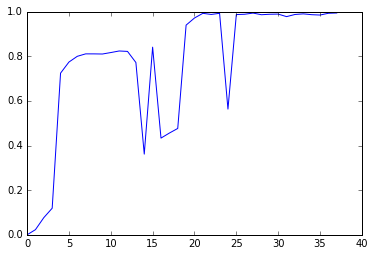

In [7]:
# The line below is mandatory to inform the notebook we want to plot directly in it
%pylab inline

# Plot the left proximeter value recorded by `epuck1`
plot(epuck1.get_log("left_prox"))

The above figure plot all the left proximeter values recorded from `epuck_1`. The x-axis corresponds to the time step of the recording values and the y-axis corresponds to the value of the left proximeter at each time step. The time step depends on the frequency at which we have run the `epuck_log` primitive. Above we have set it to 1Hz (one value recorded per second), so in the figure the x-axis represents seconds. If we would have set the frequency of the `epuck_log` routine to 2Hz, each unit on the x-axis would then correspond to half a second.

We can indicate the labels of the x and y axes and provide a title for the figure with:

Populating the interactive namespace from numpy and matplotlib


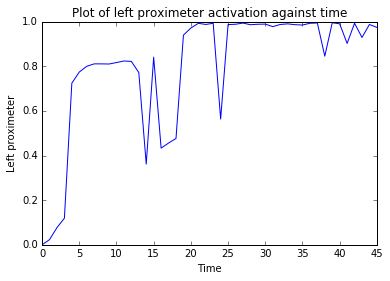

In [8]:
%pylab inline

# Plot the left proximeter value recorded by `epuck1` and set labels to the x and y axes, as well as a title
plot(epuck1.get_log("left_prox"))
xlabel("Time")
ylabel("Left proximeter")
title("Plot of left proximeter activation against time")

This write the labels and the title on the figure.

Let's now plot the glucose level of `epuck_1`:

Populating the interactive namespace from numpy and matplotlib


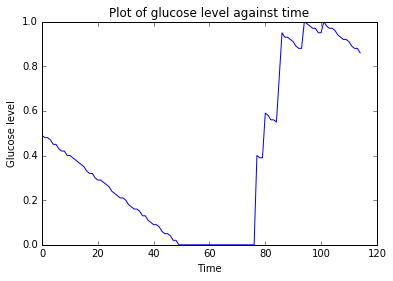

In [15]:
# The line below is mandatory to inform the notebook we want to plot directly in it
%pylab inline

# Plot the left proximeter value recorded by `epuck1`
plot(epuck1.get_log("glucose"))
xlabel("Time")
ylabel("Glucose level")
title("Plot of glucose level against time")

We can also plot two time series on the same plot. Let's plot the glucose level of both robots:

In [ ]:
# The line below is mandatory to inform the notebook we want to plot directly in it
%pylab inline

# Plot the left proximeter value recorded by `epuck1`
plot(epuck1.get_log("glucose"))
plot(epuck2.get_log("glucose"))
xlabel("Time")
ylabel("Glucose level")
title("Plot of glucose level against time")

We can add a legend to indicate which line corresponds to which robot:

Populating the interactive namespace from numpy and matplotlib


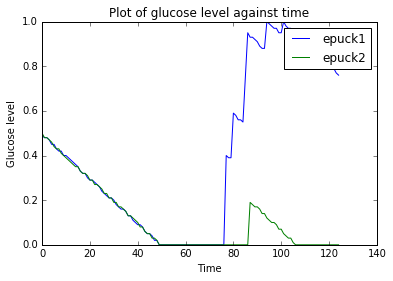

In [16]:
# The line below is mandatory to inform the notebook we want to plot directly in it
%pylab inline

# Plot the left proximeter value recorded by `epuck1`
plot(epuck1.get_log("glucose"))
plot(epuck2.get_log("glucose"))
legend(["epuck1", "epuck2"])

xlabel("Time")
ylabel("Glucose level")
title("Plot of glucose level against time")

By right-clicking on the figure and choosing "Save image as", you can store it as a PNG image. This is useful if you want to include it in your report for example.

That's all. Don't forget to properly close the session when you have finished with the notebook:

In [17]:
close_session(simulator, epuck1, epuck2)